## Used for testing to figure out how best to vertically-integrate, and whether/how to fill in missing data.

In [1]:
import numpy as np
import bottleneck
import pandas as pd
import dask as da
import dask.dataframe as dd
import xarray as xy
from scipy.interpolate import interp1d
import os.path
import matplotlib.pyplot as plt
from matplotlib import cm  #colormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from time import time
from copy import deepcopy

In [2]:
directoryTop = '/data/public/gcm/cmip5/native/'

In [3]:
def getModelListOneDir(path=None):
    fileList = []
    for f in os.listdir(path):
        if ('.nc' in f):
            if f.split('_')[2] not in fileList:
                fileList.append(f.split('_')[2])
    return fileList

modelList = getModelListOneDir(directoryTop+'day/historical/hus/')
modelList.sort()
print(len(modelList))
#modelList

31


In [4]:
def getFileListOneDir(path=None):
    fileList = []
    for f in os.listdir(path):
        if ('.nc' in f):
            fileList.append(f)
    return fileList

fileList = getFileListOneDir(directoryTop+'day/historical/hus/')

fileListOut = []
for oneFile in fileList:
    fileListOut.append('prw'+oneFile[3::])

### Figure out how to properly vertically integrate:

In [5]:
field = 'hus' #3D specific humidity
fieldOut = 'prw'
period = 'historical'
model = 'ACCESS1-0'        

In [6]:
q = xy.open_mfdataset(directoryTop+'day/'+period+'/'+field+'/'
                              +field+'_day_'+model+'_'+period+'*.nc')

test = q[field].isel(lat=slice(50,70),lon=slice(110,135),time=slice(1,20))

### xarray has a built-in wrapper for interp1d

In [5]:
new_index = np.linspace(1e5,1e3,51) 
dP = (new_index[0:-1] - new_index[1::])[0]
new_index_mid = (new_index[0:-1] + new_index[1::])/2.0

In [13]:
t1 = time()
prw = test.interp(plev=new_index_mid,method='cubic')
prwOut = prw.sum('plev')
prwOut = prwOut*dP/9.8
t2 = time()
print(t2-t1)
print(prwOut)

0.014980554580688477
<xarray.DataArray 'hus' (time: 19, lat: 20, lon: 25)>
dask.array<shape=(19, 20, 25), dtype=float32, chunksize=(19, 20, 25)>
Coordinates:
  * lat      (lat) float64 -26.88 -25.62 -24.38 -23.12 ... -5.625 -4.375 -3.125
  * lon      (lon) float64 207.2 209.1 210.9 212.8 ... 246.6 248.4 250.3 252.2
  * time     (time) datetime64[ns] 1950-01-02T12:00:00 ... 1950-01-20T12:00:00


In [14]:
t1 = time()
prw2 = test.interp(plev=new_index_mid,method='slinear')
prwOut2 = prw2.sum('plev')
prwOut2 = prwOut2*dP/9.8
t2 = time()
print(t2-t1)
print(prwOut2)

0.01460123062133789
<xarray.DataArray 'hus' (time: 19, lat: 20, lon: 25)>
dask.array<shape=(19, 20, 25), dtype=float32, chunksize=(19, 20, 25)>
Coordinates:
  * lat      (lat) float64 -26.88 -25.62 -24.38 -23.12 ... -5.625 -4.375 -3.125
  * lon      (lon) float64 207.2 209.1 210.9 212.8 ... 246.6 248.4 250.3 252.2
  * time     (time) datetime64[ns] 1950-01-02T12:00:00 ... 1950-01-20T12:00:00


(104950.0, -3950.0)

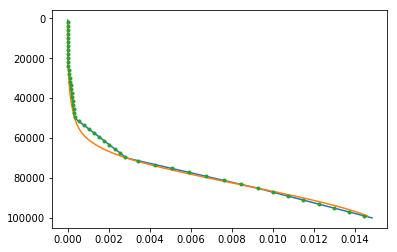

In [18]:
plt.plot(test.isel(lat=0,lon=0,time=0).values,test.plev)
plt.plot(prw.isel(lat=0,lon=0,time=0).values,prw.plev)
plt.plot(prw2.isel(lat=0,lon=0,time=0).values,prw2.plev,'.')
plt.ylim(plt.ylim()[::-1])

#### Is it a good idea to interpolate? -- more realistic in this example, especially between 750 and 500mb, but other examples can sometimes give weird behavior in the cubic spline.

#### Probably better to use the 'slinear' version which doesn't risk extrapolating too much.

#### Works across spatial sub-domain:

In [19]:
prwOut.attrs = q.attrs
prwOut.name = fieldOut
prwOut.attrs['units'] = 'mm'
prwOut.attrs['standard_name'] = 'column integrated moisture'
prwOut.attrs['long_name'] = 'column integrated moisture'
prwOut.attrs['notes'] = 'hus field integrated in python NG 4 Jan, 2019'

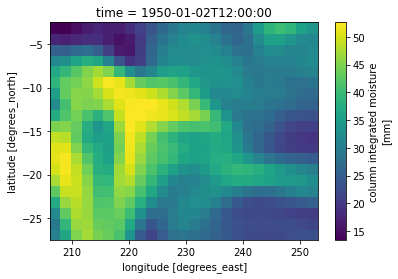

In [20]:
prwOut.isel(time=0).plot()

### Testing with a model that fails because of NaNs:

In [59]:
field = 'hus' #3D specific humidity
fieldOut = 'prw'
period = 'historical'
model = 'MIROC4h'        
fileList = getFileListOneDir(directoryTop+'day/'+period+'/'+field+'/')
fileListModel = [oneFile for oneFile in fileList if model in oneFile]
q = xy.open_dataset(directoryTop+'day/'+period+'/'+field+'/'+fileListModel[0],
                      chunks={'plev': -1,'lat':180,'lon':180,'time':365})


#### there is no value below 850mb over most land! ... and wherever there's low pressure over the ocean too

<xarray.DataArray 'hus' (plev: 8, lat: 320, lon: 640)>
dask.array<shape=(8, 320, 640), dtype=float32, chunksize=(8, 180, 180)>
Coordinates:
    time     datetime64[ns] 1950-01-01T12:00:00
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03
  * lat      (lat) float64 -89.57 -89.01 -88.45 -87.89 ... 88.45 89.01 89.57
  * lon      (lon) float64 0.0 0.5625 1.125 1.688 ... 357.8 358.3 358.9 359.4
Attributes:
    standard_name:     specific_humidity
    long_name:         Specific Humidity
    units:             1
    original_name:     Q
    original_units:    kg/kg
    history:           2011-05-03T22:47:48Z altered by CMOR: Converted units ...
    cell_methods:      time: mean
    cell_measures:     area: areacella
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

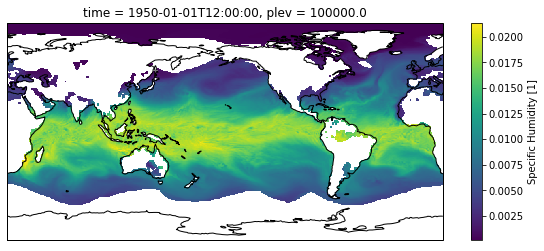

In [79]:
temp = q[field].isel(time=0)
plt.figure(figsize=[10,4])
ax = plt.subplot(111,projection=ccrs.PlateCarree(200))
temp.isel(plev=0).plot(ax=ax,transform=ccrs.PlateCarree())
ax.coastlines()
temp

In [80]:
import gridfill
import numpy.ma as ma

In [81]:
masked = (temp.isel(plev=0).squeeze().values)
masked = ma.masked_invalid(masked)
masked 

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [0.0002077703975373879, 0.0002077703975373879,
         0.0002077703975373879, ..., 0.00020647537894546986,
         0.00020647537894546986, 0.0002077703975373879],
        [0.00021554046543315053, 0.00021554046543315053,
         0.00021554046543315053, ..., 0.00021554046543315053,
         0.00021554046543315053, 0.00021554046543315053],
        [0.00021942549210507423, 0.00021942549210507423,
         0.00021942549210507423, ..., 0.00021942549210507423,
         0.00021942549210507423, 0.00021942549210507423]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, 

In [85]:
def fillOneLevel(y):
    masked = ma.masked_invalid(y.squeeze().values)
    filledArray = gridfill.fill(masked,1,0,0.0001,cyclic=True)
    y.values = filledArray[0][None,:] 
    return y

filledtemp = temp.groupby('plev').apply(fillOneLevel) 

##### it quickly goes to zero whereever there is missing data: 


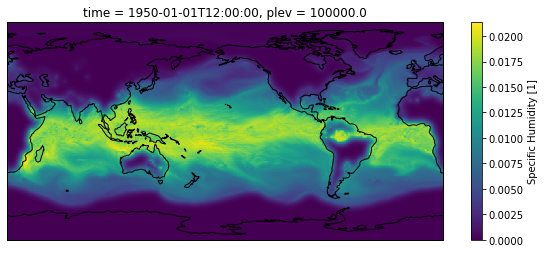

In [57]:
plt.figure(figsize=[10,4])
ax = plt.subplot(111,projection=ccrs.PlateCarree(200))
filledtemp.isel(plev=0).plot(ax=ax,transform=ccrs.PlateCarree())
ax.coastlines()

In [12]:
t1 = time()
prwPoisson = filledtemp.interp(plev=new_index_mid,method='slinear').sum('plev')
prwPoisson = prwPoisson*dP/9.8
t2 = time()
print(t2-t1)

0.15688014030456543


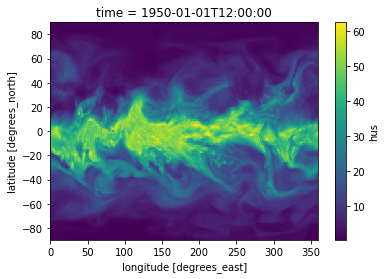

In [13]:
prwPoisson.plot()

#### Compared with backfilling the value from one level up:

In [14]:
t1 = time()
qtemp = temp.bfill('plev').dropna('plev') 
prwFill = qtemp.interp(plev=new_index_mid,method='slinear').sum('plev')
prwFill = prwFill*dP/9.8
t2 = time()
print(t2-t1)

0.0641927719116211


/home/ngoldenson/miniconda2/envs/forPy3/lib/python3.6/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


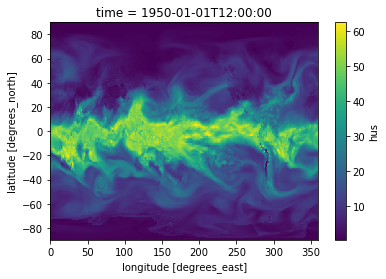

In [15]:
prwFill.plot() 

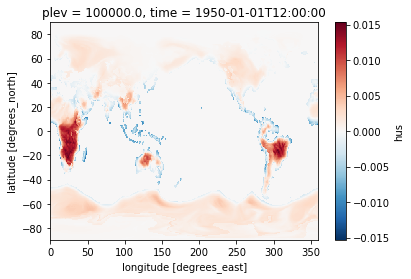

In [16]:
(qtemp - filledtemp).isel(plev=0).plot()

#### one more comparison. if we fillna(0):


In [17]:
t1 = time()
qtempNA = temp.fillna(0).dropna('plev') 
prwNA = qtempNA.interp(plev=new_index_mid,method='slinear').sum('plev')
prwNA = prwNA*dP/9.8
t2 = time()
print(t2-t1)

0.05237603187561035


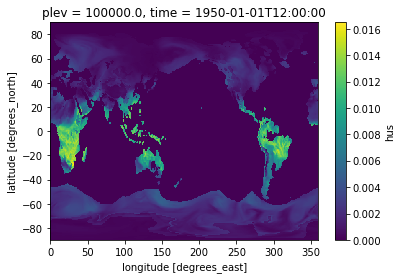

In [18]:
(qtemp-qtempNA).isel(plev=0).plot()

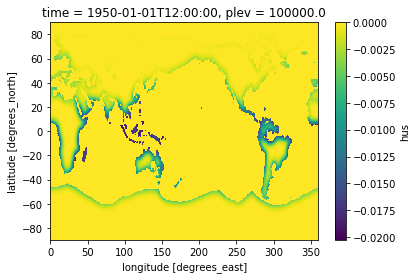

In [19]:
(qtempNA-filledtemp).isel(plev=0).plot()

#### And so it appears that filling with NaNs gets you closer to the Poisson interpolation, except at the edges

### What about using sea level pressure and 'huss' over the ocean so there's always a realistic bottom point? 

#### Recalling where data is missing:

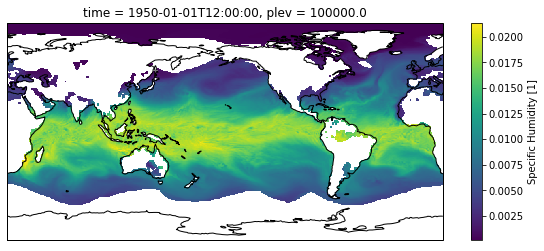

In [56]:
plt.figure(figsize=[10,4])
ax = plt.subplot(111,projection=ccrs.PlateCarree(200))
q['hus'].isel(time=0,plev=0).plot(ax=ax,transform=ccrs.PlateCarree())
ax.coastlines()

In [91]:
field = 'psl'
psl = xy.open_dataset(directoryTop+'day/'+period+'/'+field+'/psl_day_MIROC4h_historical_r1i1p1_19500101-19501231.nc') #, #psl_day_ACCESS1-0_historical_r1i1p1_19500101-19741231.nc',
                     # chunks={'lat':-1,'lon':-1,'time':12})
#psl['psl']

In [92]:
field = 'huss'
huss = xy.open_dataset(directoryTop+'day/'+period+'/'+field+'/huss_day_MIROC4h_historical_r1i1p1_19500101-19501231.nc') #, #huss_day_CCSM_historical_r1i1p1_19500101-19741231.nc',
                     # chunks={'lat':-1,'lon':-1,'time':12})
#huss['huss']

Text(0.5, 1.0, 'Poisson-filled 1000mb')

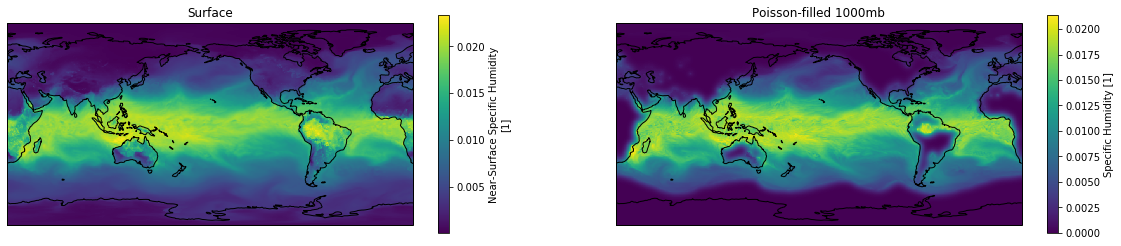

In [89]:
plt.figure(figsize=[20,4])
ax = plt.subplot(121,projection=ccrs.PlateCarree(200))
huss['huss'].isel(time=0).plot(ax=ax,transform=ccrs.PlateCarree())
ax.coastlines()
plt.title('Surface')

ax = plt.subplot(122,projection=ccrs.PlateCarree(200))
filledtemp.isel(plev=0).plot(ax=ax,transform=ccrs.PlateCarree())
ax.coastlines()
plt.title('Poisson-filled 1000mb')

#### Over the oceans, where we're interested in, it's not so different from the interpolated 1000mb level

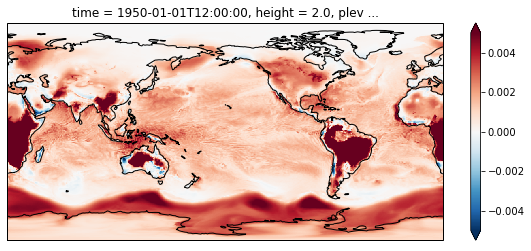

In [90]:
plt.figure(figsize=[10,4])
ax = plt.subplot(111,projection=ccrs.PlateCarree(200))
(huss['huss'].isel(time=0)-filledtemp.isel(plev=0)).plot(ax=ax,transform=ccrs.PlateCarree(),\
                                                         vmin=-0.005,vmax=0.005,cmap=cm.RdBu_r)
ax.coastlines()
#ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')

In [26]:
surfaceQ = huss['huss'].isel(time=0) #sel(time=slice('19500101','19500201'))
pslTemp = psl['psl'].isel(time=0) #sel(time=slice('19500101','19500201'))


In [29]:
#this method is *very* slow comparatively
def applyInterp(y):
    q = y.values.tolist()
    testcoord = y.allpoints.data.tolist()
    toAppend = surfaceQ.sel(lat=testcoord[0],lon=testcoord[1]).values.tolist()
    pslToAppend = pslTemp.sel(lat=testcoord[0],lon=testcoord[1]).values.tolist()
    
    q = [toAppend]+q
    pressure = [pslToAppend]+pressureInit
    new_index = np.linspace(pslToAppend,1e3,51) #101
    dP = (new_index[0:-1] - new_index[1::])[0]
    new_index_mid = (new_index[0:-1] + new_index[1::])/2.0
    f = interp1d(pressure,q,kind='slinear')
    ynew = f(new_index_mid)
    return xy.DataArray(np.nansum(ynew)*dP/9.8)
    
t1 = time()
pressureInit = q['hus'].plev.values.tolist()
qtempPSL = q['hus'].isel(time=0) #.sel(time=slice('19500101','19500201'))
qtempPSL = qtempPSL.stack(allpoints=['lat','lon']).squeeze() #.dropna('plev')
prwPSL = qtempPSL.groupby('allpoints').apply(applyInterp)
prwPSL = prwPSL.unstack('allpoints')
t2 = time()
print(str(t2-t1)+' s, or '+str((t2-t1)/60.0)+' min')

5351.68877363205 s, or 89.19481289386749 min


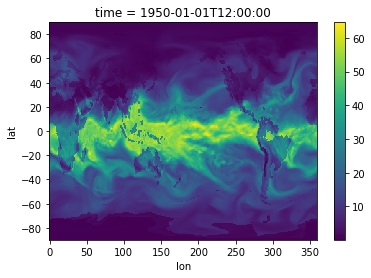

In [32]:
prwPSL.plot()

In [33]:
#let's make sure I don't get stuck waiting 89 minutes again:
prwPSL.to_netcdf('/work/ngoldenson/prwTEMP.nc')

In [24]:
prwPSL = xy.open_dataset('/work/ngoldenson/prwTEMP.nc')
prwPSL = prwPSL['__xarray_dataarray_variable__']

#### The verion with sea level pressure used with surface specific humidity is only supposed to be valid over the ocean. So, ignoring land area, ... yeesh difference is 10% of the AR threshold (20mm)

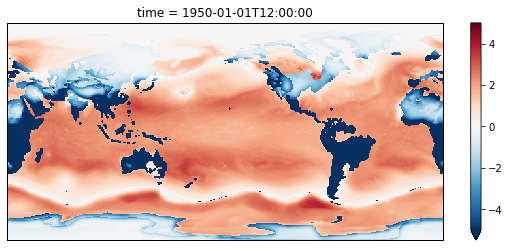

In [99]:
plt.figure(figsize=[10,4])
ax = plt.subplot(111,projection=ccrs.PlateCarree(200))
(prwPSL-prwPoisson).plot(ax=ax,vmin=-5,vmax=5,transform=ccrs.PlateCarree(),cmap=cm.RdBu_r)
#ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')

#### These are the most different so far. Percent difference, masking land:

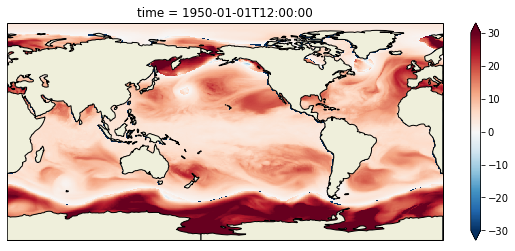

In [94]:
#percent difference
plt.figure(figsize=[10,4])
ax = plt.subplot(111,projection=ccrs.PlateCarree(200))
((prwPSL-prwPoisson)/prwPSL*100).plot(ax=ax,vmin=-30,vmax=30,transform=ccrs.PlateCarree(),cmap=cm.RdBu_r)
ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')


#### The sea-level-pressure one is always greater than the poisson one, generally by as much as 30 percent. 

#### Plot the sea level pressure itself -- it has that same anomaly pattern as above.

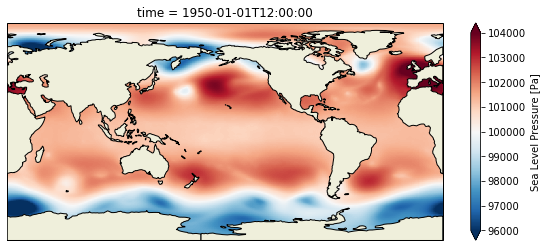

In [95]:
plt.figure(figsize=[10,4])
ax = plt.subplot(111,projection=ccrs.PlateCarree(200))
psl['psl'].isel(time=0).plot(ax=ax,transform=ccrs.PlateCarree(),cmap=cm.RdBu_r,vmin=96000,vmax=104000)
ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')

#### Places where sea-level pressure is further from 1000mb are where there is greater divergence between the column-integrated totals

#### But why is it biased high regardless? 
##### If PSL is high, you're missing that extra little bit of the moisture column below 1000mb.
##### If PSL is low, there was no value, and the filled value goes quickly to zero. Actual surface specific humidity is bigger than the filled 1000mb value there. 


### What about comparing the Poisson and the fillNA versions then?

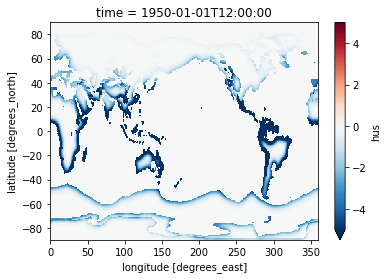

In [43]:
(prwNA-prwPoisson).plot(vmin=-5,vmax=5,cmap=cm.RdBu_r) #raw difference

#### FillNA unsurprisingly results in lower values, especially at the coasts/edges.

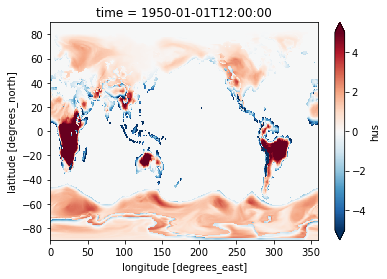

In [32]:
(prwFill-prwPoisson).plot(vmin=-5,vmax=5,cmap=cm.RdBu_r) #raw difference

#### Reassuringly similar over the ocean, but filling down the value from one level up is poorly justified over land

## Can I get the Poisson filling method to perform better, and go less quickly to zero?

In [115]:
temp.isel(plev=0) #cyclic assumes cyclic in the 2nd dimension, but latitude is first!

<xarray.DataArray 'hus' (lat: 320, lon: 640)>
dask.array<shape=(320, 640), dtype=float32, chunksize=(180, 180)>
Coordinates:
    time     datetime64[ns] 1950-01-01T12:00:00
    plev     float64 1e+05
  * lat      (lat) float64 -89.57 -89.01 -88.45 -87.89 ... 88.45 89.01 89.57
  * lon      (lon) float64 0.0 0.5625 1.125 1.688 ... 357.8 358.3 358.9 359.4
Attributes:
    standard_name:     specific_humidity
    long_name:         Specific Humidity
    units:             1
    original_name:     Q
    original_units:    kg/kg
    history:           2011-05-03T22:47:48Z altered by CMOR: Converted units ...
    cell_methods:      time: mean
    cell_measures:     area: areacella
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

In [117]:
masked.T.shape

(640, 320)

In [157]:
def fillOneLevel(y):
    masked = ma.masked_invalid(y.squeeze().values)
    filledArray = gridfill.fill(masked.T,0,1,1e-5,itermax=1e5,cyclic=True) #,initzonal=True)
    print(filledArray[0].shape)
    y.values = filledArray[0].T
    return y

temp = q['hus'].isel(time=0)
#filledtemp2 = temp.groupby('plev').apply(fillOneLevel) 
filledtemp2 = fillOneLevel(temp.isel(plev=0))

(640, 320)


Text(0.5, 1.0, 'New - Old')

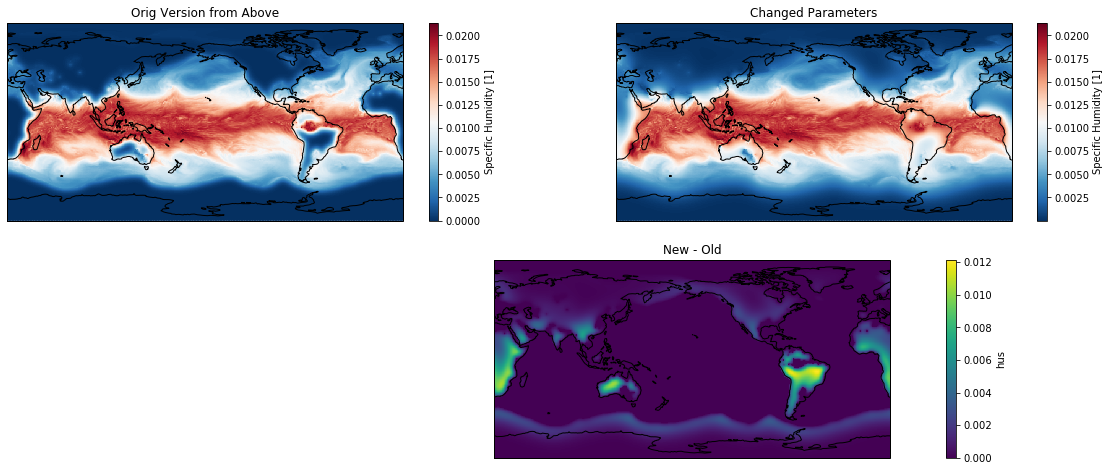

In [158]:
plt.figure(figsize=[20,8])
ax = plt.subplot(221,projection=ccrs.PlateCarree(200))
filledtemp.isel(plev=0).plot(ax=ax,transform=ccrs.PlateCarree(),cmap=cm.RdBu_r) #,vmin=96000,vmax=104000)
ax.coastlines()
plt.title('Orig Version from Above')
ax = plt.subplot(222,projection=ccrs.PlateCarree(200))
filledtemp2.plot(ax=ax,transform=ccrs.PlateCarree(),cmap=cm.RdBu_r) #,vmin=96000,vmax=104000)
ax.coastlines()
plt.title('Changed Parameters')
ax = plt.subplot(212,projection=ccrs.PlateCarree(200))
(filledtemp2 - filledtemp.isel(plev=0)).plot(ax=ax,transform=ccrs.PlateCarree()) #,cmap=cm.RdBu_r) #,vmin=96000,vmax=104000)
ax.coastlines()
plt.title('New - Old')

Text(0.5, 1.0, "'huss' - new filled")

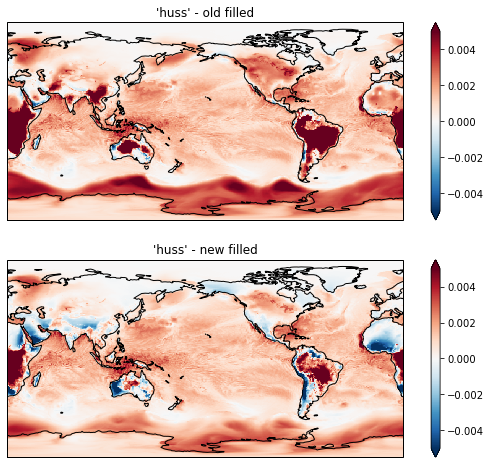

In [159]:
plt.figure(figsize=[10,8])
ax = plt.subplot(211,projection=ccrs.PlateCarree(200))
(huss['huss'].isel(time=0)-filledtemp.isel(plev=0)).plot(ax=ax,transform=ccrs.PlateCarree(),\
                                                         vmin=-0.005,vmax=0.005,cmap=cm.RdBu_r)
ax.coastlines()
plt.title("'huss' - old filled")

ax = plt.subplot(212,projection=ccrs.PlateCarree(200))
(huss['huss'].isel(time=0)-filledtemp2).plot(ax=ax,transform=ccrs.PlateCarree(),\
                                                         vmin=-0.005,vmax=0.005,cmap=cm.RdBu_r)
ax.coastlines()
plt.title("'huss' - new filled")


#### Okay, so increasing 'itermax' (the number of iterations) was key -- before it wasn't enough to converse. 'Initzonal' is actually not helpful, and unnecessary if you're iterating enough to converge.

#### Lessons: don't trust this Poisson extrapolation over land at all. Over the ocean, errors are minimal where there was missing data -- no worse than in the places where some of the moisture column is missing because surface pressure is higher than 1000mb.

### Lastly plot the final integrated specific humidity to compare:

In [163]:
def fillOneLevel(y):
    masked = ma.masked_invalid(y.squeeze().values)
    filledArray = gridfill.fill(masked.T,0,1,1e-5,itermax=1e5,cyclic=True) #,initzonal=True)
    #print(filledArray[0].shape)
    y.values = filledArray[0].T[None,:]
    return y

temp = q['hus'].isel(time=0)
filledtemp2 = temp.groupby('plev').apply(fillOneLevel) 

In [164]:
t1 = time()
prwPoisson2 = filledtemp2.interp(plev=new_index_mid,method='slinear').sum('plev')
prwPoisson2 = prwPoisson2*dP/9.8
t2 = time()
print(t2-t1)

0.19536209106445312


Text(0.5, 1.0, 'Down-to-sea-level version MINUS Poisson filled (new)')

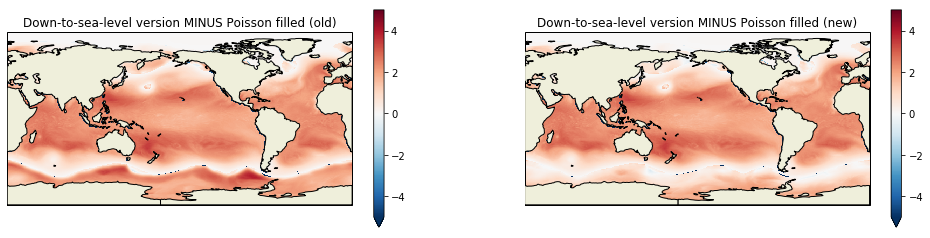

In [171]:
plt.figure(figsize=[17,4])
ax = plt.subplot(121,projection=ccrs.PlateCarree(200))
((prwPSL-prwPoisson)).plot(ax=ax,vmin=-5,vmax=5,transform=ccrs.PlateCarree(),cmap=cm.RdBu_r)
ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
plt.title('Down-to-sea-level version MINUS Poisson filled (old)')
ax = plt.subplot(122,projection=ccrs.PlateCarree(200))
((prwPSL-prwPoisson2)).plot(ax=ax,vmin=-5,vmax=5,transform=ccrs.PlateCarree(),cmap=cm.RdBu_r)
ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
plt.title('Down-to-sea-level version MINUS Poisson filled (new)')


##### Let's see % difference too:

Text(0.5, 1.0, 'Down-to-sea-level version MINUS Poisson filled (new)')

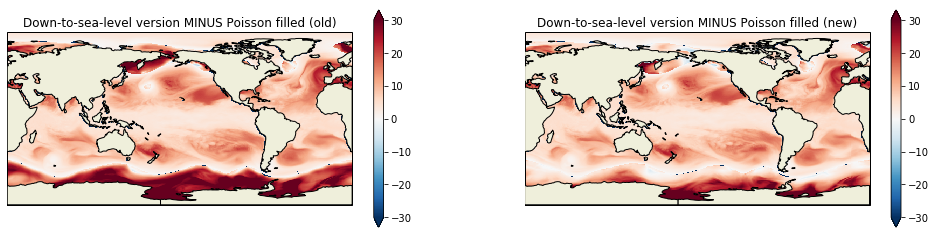

In [173]:
plt.figure(figsize=[17,4])
ax = plt.subplot(121,projection=ccrs.PlateCarree(200))
((prwPSL-prwPoisson)/prwPSL*100).plot(ax=ax,vmin=-30,vmax=30,transform=ccrs.PlateCarree(),cmap=cm.RdBu_r)
ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
plt.title('Down-to-sea-level version MINUS Poisson filled (old)')
ax = plt.subplot(122,projection=ccrs.PlateCarree(200))
((prwPSL-prwPoisson2)/prwPSL*100).plot(ax=ax,vmin=-30,vmax=30,transform=ccrs.PlateCarree(),cmap=cm.RdBu_r)
ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
plt.title('Down-to-sea-level version MINUS Poisson filled (new)')


### I am now satisfied that the errors where there was no data are now no worse than the errors where PSL exceeds 1000mb and that last bottom part of the colunm is missing.

#### ...with the caveat not to use it over land or too close to Antarctica.

##### It also seems important to report the function and parameters used for the Poisson filling in any paper.